This notebook follows from the notebook `grib_test__FOR_0125_dataset_(local_temp_inspection).ipynb`. This notebook extends the local-inspection to a sample of points from grid-sampling.

In [1]:
import pygrib
msgs = pygrib.open(r"C:\SUSTech\datasets_of_graduation_project\0220.grib")

## Grid-sampling
Given the lat-lon range (a rectangular region) of the dataset, the grid-sampling is to uniformly sample points from it.

In [2]:
LAT_RANGE = (90, 66.5) # the entire map is from 90 degree to 66.5 degree, closed interval
LON_RANGE = (-180, 179.5)

In [3]:
LAT_RESOL = 5 # the grid resolution of latitudes; two distinct lats are differred by 5 degrees
LON_RESOL = 30
LAT_VICINITY_R = 1 # Consider the average of the vicinity of each grid point, to reduce the noise. The radius of the vicinity is 1 degree here. This value should not exceed LAT_RESOL
LON_VICINITY_R = 1

In [4]:
DISTINCT_LATS = [90 - i * LAT_RESOL 
    for i in range(int((abs(LAT_RANGE[1] - LAT_RANGE[0]) // LAT_RESOL) + 1))] # round down when sampling points
DISTINCT_LONS = [-180 + i * LON_RESOL 
    for i in range(int((abs(LON_RANGE[1] - LON_RANGE[0]) // LON_RESOL) + 1))]

In [6]:
import numpy as np
from bidict import bidict
msg = msgs[1]

# (lat, lon) -> (lat_idx, lon_idx)
latlon_to_latlonIdx = bidict()
for lat in DISTINCT_LATS:
    for lon in DISTINCT_LONS:
        latlon_to_latlonIdx[(lat, lon)] = (np.where(msg["distinctLatitudes"] == lat)[0][0], 
                                     np.where(msg["distinctLongitudes"] == lon)[0][0])

print(latlon_to_latlonIdx)

# (lat_idx, lon_idx) -> ((lat1_idx, lat2_idx), (lon1_idx, lon2_idx)), 
# with lat1_idx <= lat2_idx, lon1_idx <= lon2_idx
latlonIdx_to_vicinityIdx = bidict()
for latlonIdx in latlon_to_latlonIdx.values():
    lat_idx, lon_idx = latlonIdx
    lat1_idx = int(max(0, 
                lat_idx - LAT_VICINITY_R // 0.25))
    lat2_idx = int(min(len(msg["distinctLatitudes"]), 
                lat_idx + LAT_VICINITY_R // 0.25 + 1))
    lon1_idx = int(max(0, 
                lon_idx - LON_VICINITY_R // 0.25))
    lon2_idx = int(min(len(msg["distinctLongitudes"]), 
                lon_idx + LON_VICINITY_R // 0.25 + 1))
    latlonIdx_to_vicinityIdx[latlonIdx] = ((lat1_idx, lat2_idx), (lon1_idx, lon2_idx))
    
print(latlonIdx_to_vicinityIdx)


bidict({(90, -180): (0, 0), (90, -150): (0, 120), (90, -120): (0, 240), (90, -90): (0, 360), (90, -60): (0, 480), (90, -30): (0, 600), (90, 0): (0, 720), (90, 30): (0, 840), (90, 60): (0, 960), (90, 90): (0, 1080), (90, 120): (0, 1200), (90, 150): (0, 1320), (85, -180): (20, 0), (85, -150): (20, 120), (85, -120): (20, 240), (85, -90): (20, 360), (85, -60): (20, 480), (85, -30): (20, 600), (85, 0): (20, 720), (85, 30): (20, 840), (85, 60): (20, 960), (85, 90): (20, 1080), (85, 120): (20, 1200), (85, 150): (20, 1320), (80, -180): (40, 0), (80, -150): (40, 120), (80, -120): (40, 240), (80, -90): (40, 360), (80, -60): (40, 480), (80, -30): (40, 600), (80, 0): (40, 720), (80, 30): (40, 840), (80, 60): (40, 960), (80, 90): (40, 1080), (80, 120): (40, 1200), (80, 150): (40, 1320), (75, -180): (60, 0), (75, -150): (60, 120), (75, -120): (60, 240), (75, -90): (60, 360), (75, -60): (60, 480), (75, -30): (60, 600), (75, 0): (60, 720), (75, 30): (60, 840), (75, 60): (60, 960), (75, 90): (60, 1080)

## Compute the `ts_2mTemp` for local inspection

In [7]:
# delete `msg` if it is a variable
if "msg" in locals(): del msg 

ts_2mTemp = dict()
for (lat, lon) in latlon_to_latlonIdx.keys(): 
    msgs.rewind()
    lat1_idx, lat2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][0]
    lon1_idx, lon2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][1]
    ts_2mTemp[(lat, lon)] = np.array([np.mean(msg["values"][lat1_idx:lat2_idx, lon1_idx:lon2_idx]) for msg in msgs])

In [8]:
N = 8*15*12 # 8 hours per day, 15 days per month, 12 months per year
N_years = 80 # 1945, 1942, ..., 2024, 80 years in total

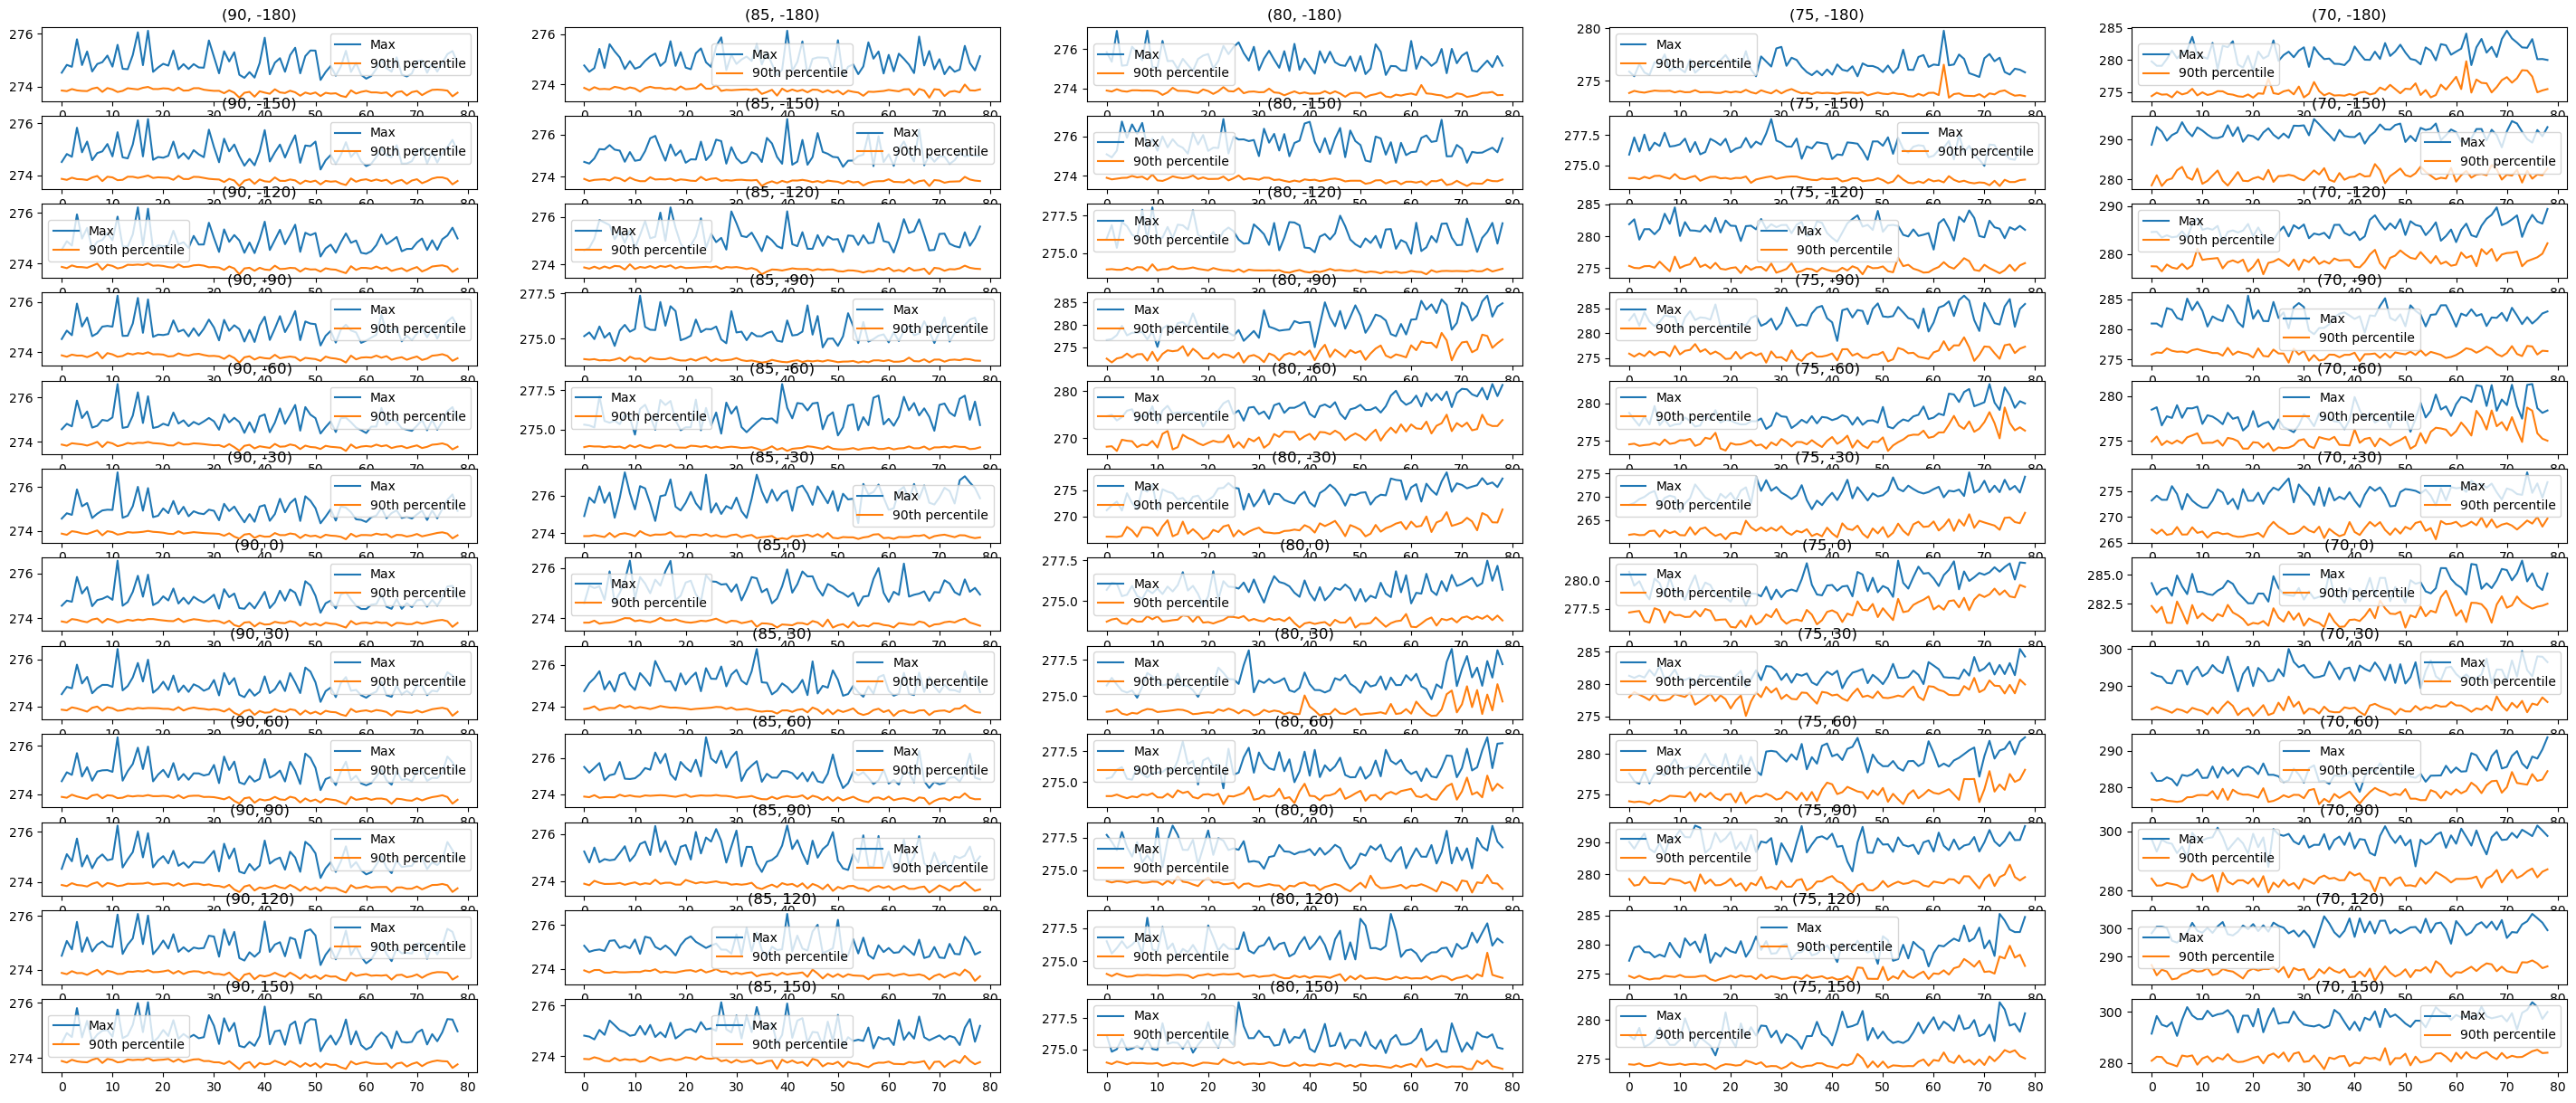

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(DISTINCT_LONS), len(DISTINCT_LATS), figsize=(3*len(DISTINCT_LONS), 3*len(DISTINCT_LATS)))
for i, lon in enumerate(DISTINCT_LONS):
    for j, lat in enumerate(DISTINCT_LATS):
        # maximize the temp over each year 
        ts_annualMax_2mTemp = np.array([ts_2mTemp[(lat, lon)][y*N:(y+1)*N].max() 
                                             for y in range(0, N_years-1)])
        # get the 90th percentile of the target temp over each year 
        ts_annual90Percentile_2mTemp = np.array([np.percentile(ts_2mTemp[(lat, lon)][y*N:(y+1)*N], 90) 
                                             for y in range(0, N_years-1)])
        ax[i, j].plot(ts_annualMax_2mTemp, label="Max")
        ax[i, j].plot(ts_annual90Percentile_2mTemp, label="90th percentile")
        ax[i, j].legend()
        ax[i, j].set_title(f"({lat}, {lon})")
        
plt.show()

In [10]:
msgs.close()

## Save the data

In [23]:
print(ts_2mTemp[(80, 60)].shape)

# save the data ts_2mTemp
import h5py
path = r"outputs\ts_2mTemp_(5_30_1_1).h5"

with h5py.File(path, "w") as f: # (LAT_RESOL, LON_RESOL, LAT_VICINITY_R, LON_VICINITY_R) = (5, 30, 1, 1)
    for key, value in ts_2mTemp.items():
        key_str = f"{key[0]}_{key[1]}"  # convert the keys ((lat, lon) tuples) to strings
        f.create_dataset(key_str, data=value)

(114720,)


In [24]:
# read the data back
with h5py.File(path, "r") as f:
    ts_2mTemp_read = {}
    for key in f.keys():
        key_parts = key.split('_')
        key_tuple = (int(key_parts[0]), int(key_parts[1]))
        ts_2mTemp_read[key_tuple] = np.array(f[key])

# check if the data is saved correctly and read correctly
print(ts_2mTemp_read.keys() == ts_2mTemp.keys())
print(all([np.array_equal(ts_2mTemp_read[key], ts_2mTemp[key]) for key in ts_2mTemp.keys()]))

True
True


## Refine the visualization

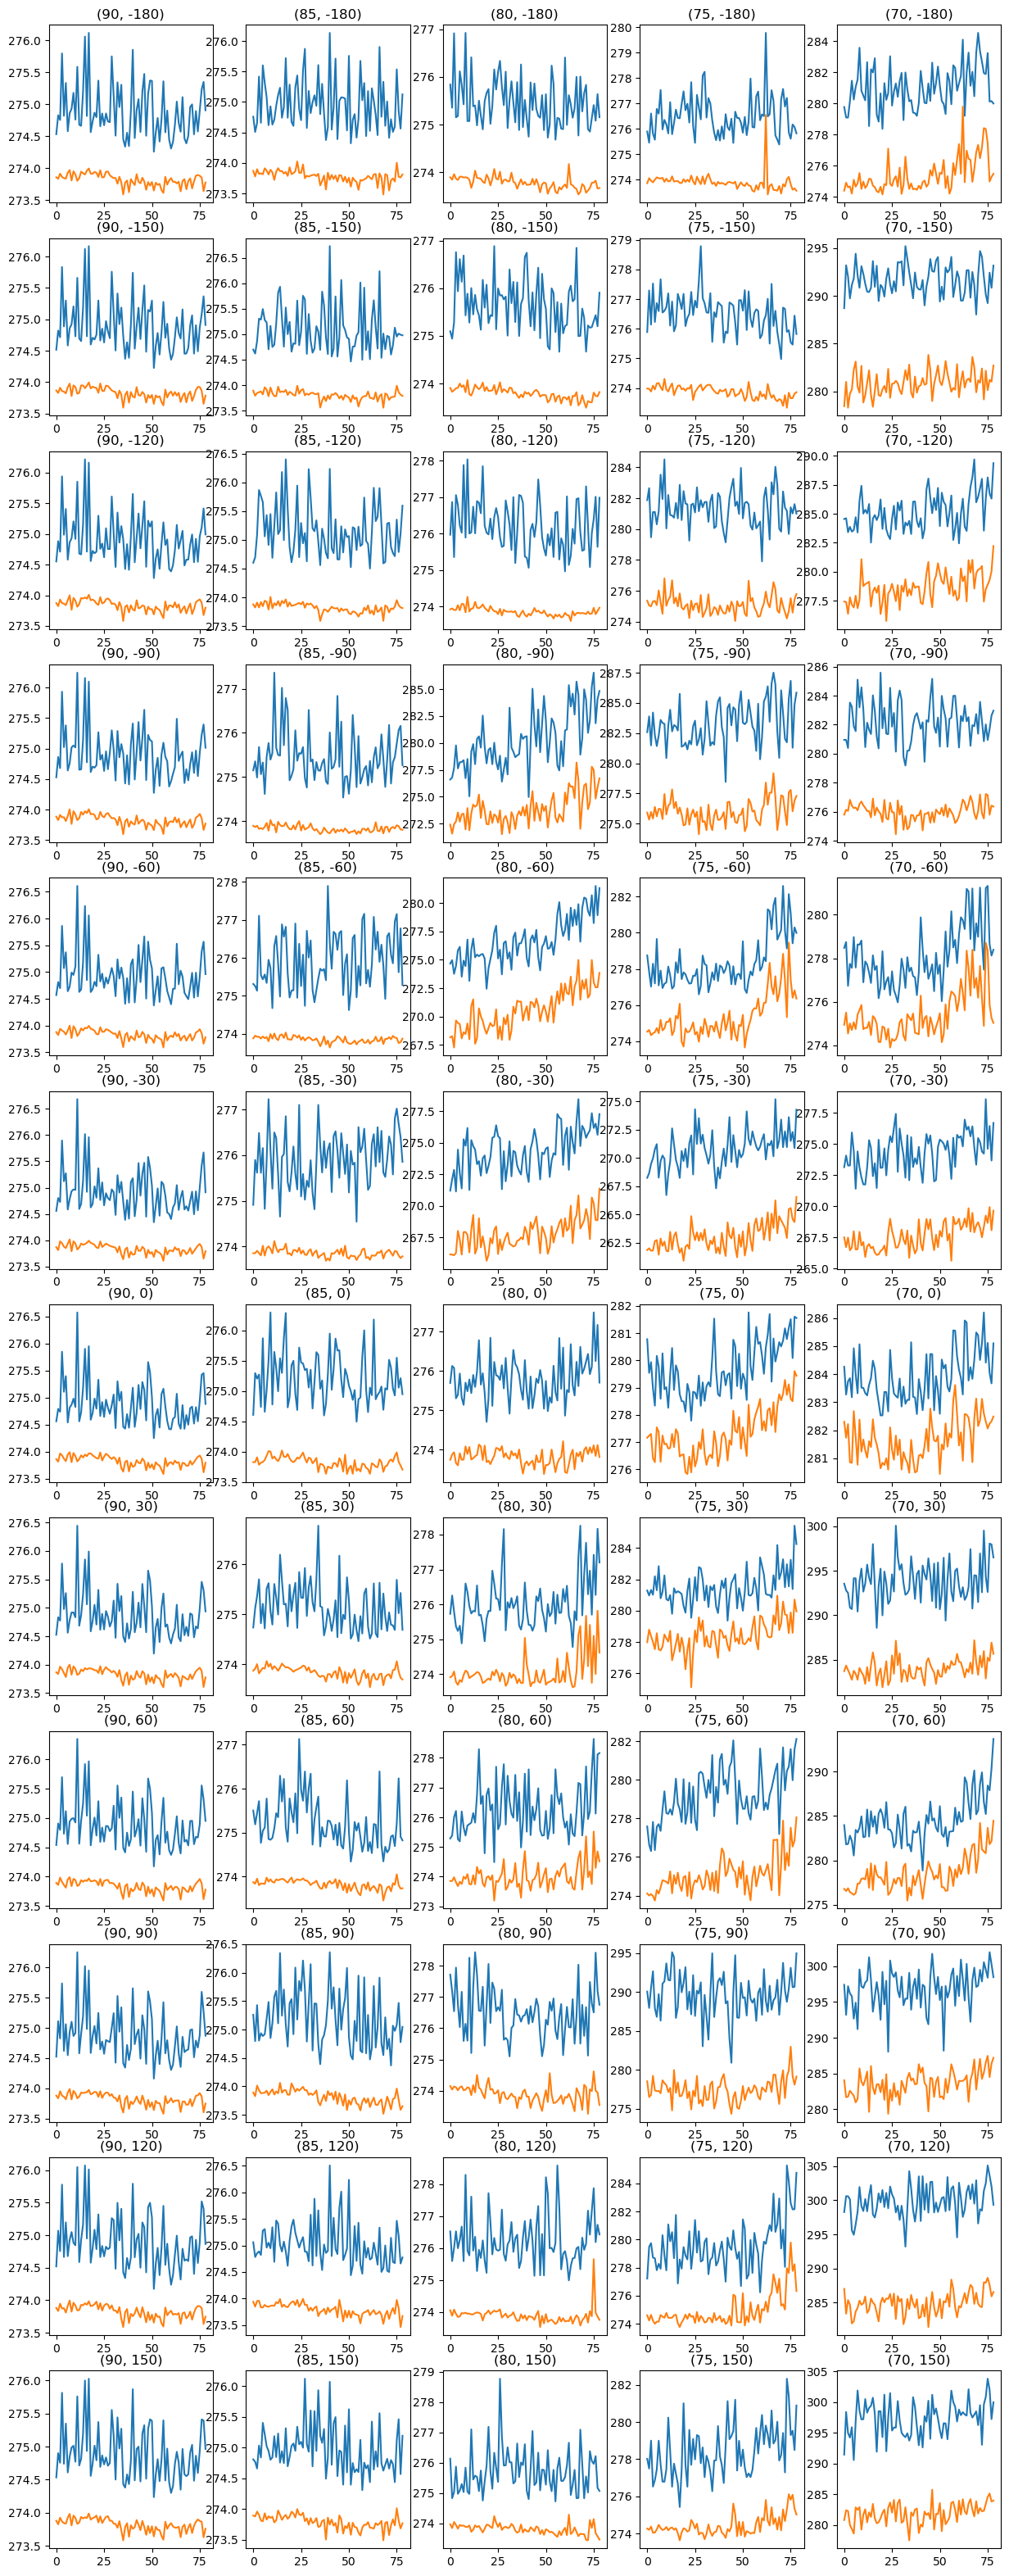

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(DISTINCT_LONS), len(DISTINCT_LATS), figsize=(15, 40))
for i, lon in enumerate(DISTINCT_LONS):
    for j, lat in enumerate(DISTINCT_LATS):
        # maximize the temp over each year 
        ts_annualMax_2mTemp = np.array([ts_2mTemp[(lat, lon)][y*N:(y+1)*N].max() 
                                             for y in range(0, N_years-1)])
        # get the 90th percentile of the target temp over each year 
        ts_annual90Percentile_2mTemp = np.array([np.percentile(ts_2mTemp[(lat, lon)][y*N:(y+1)*N], 90) 
                                             for y in range(0, N_years-1)])
        ax[i, j].plot(ts_annualMax_2mTemp, label="Max")
        ax[i, j].plot(ts_annual90Percentile_2mTemp, label="90th percentile")
        # ax[i, j].legend()
        ax[i, j].set_title(f"({lat}, {lon})")
        
plt.show()
fig.savefig(r"outputs\ts_2mTemp_(5_30_1_1).png")